In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# 定义常量（保持不变）
r = 0.5  # 最大增长率
K = 1e9  # 环境容纳量
mu = 0.1  # 基础死亡率
alpha = 0.1  # 葡萄糖促进生长系数
K_g = 0.8  # 葡萄糖半饱和常数
beta = 0.05  # SCFAs抑制生长系数
K_s = 10.0  # SCFAs半抑制常数
n = 2  # Hill系数
gamma = 0.01  # GLP-1对生长的影响系数
K_p = 1.0  # GLP-1半饱和常数
delta = 0.1  # DLPC包裹对生长的抑制系数
V_max = 0.5  # 最大SCFAs产生速率
K_m = 2.0  # SCFAs产生的Michaelis常数
k_deg = 0.1  # SCFAs降解率
k_inh = 0.05  # SCFAs产物抑制系数
K_inh = 20.0  # SCFAs产物抑制半饱和常数
D_SCFAs = 0.1  # SCFAs扩散系数
a_SCFAs = 0.2  # SCFAs酶表达系数
K_SCFAs = 5.0  # SCFAs酶表达半饱和常数
lambda_E = 0.1  # 酶降解率
nu_max = 0.1  # 最大GLP-1表达速率
lambda_nu = 0.5  # GLP-1表达启动速率
delta_GLP = 0.2  # GLP-1降解率
epsilon = 1e-5  # GLP-1被细菌重吸收的速率
D_GLP = 0.15  # GLP-1扩散系数
sigma = 0.4  # DLPC对细菌生长的抑制系数
k_uptake = 2  # 葡萄糖摄取速率
D_Glu = 0.2  # 葡萄糖扩散系数
tau = 1.0  # 最大时滞时间
k_BCoAT = 0.1  # BCoAT表达速率
k_BCoAT_deg = 0.05  # BCoAT降解速率
k_GLP_BCoAT = 0.1  # BCoAT对GLP-1表达的影响系数

# 外部环境条件
Glu_ext = 11.0
SCFAs_ext = 0.0
GLP1_ext = 0.0
DLPC = 1.0

In [2]:
# 基于时间的历史数据
time_points = np.array([0, 2, 4, 6, 8, 10, 12])
glp1_data_time = {
    'chassis': np.array([
        [0.031, 0.03, 0.039, 0.037, 0.052, 0.045, 0.078],
        [0.018, 0.025, 0.036, 0.041, 0.044, 0.061, 0.076],
        [0.022, 0.036, 0.033, 0.04, 0.042, 0.055, 0.037]
    ]),
    'engineered': np.array([
        [0.033, 0.122, 1.278, 3.296, 6.172, 6.828, 7.105],
        [0.025, 0.136, 1.369, 4.014, 6.565, 6.751, 7.331],
        [0.047, 0.217, 1.515, 3.552, 5.987, 6.609, 6.909]
    ]),
    'engineered_dlpc': np.array([
        [0.044, 0.198, 0.889, 1.491, 2.814, 3.582, 3.8],
        [0.058, 0.105, 0.765, 1.552, 3.01, 3.711, 4.001],
        [0.03, 0.206, 0.792, 1.535, 3.053, 3.412, 3.786]
    ])
}

# 基于葡萄糖浓度的历史数据
glucose_concentrations = np.array([0, 2, 5, 8, 11])
glp1_data_glucose = {
    'chassis': np.array([
        [0.038, 0.055, 0.067, 0.053, 0.078],
        [0.054, 0.089, 0.043, 0.064, 0.076],
        [0.087, 0.041, 0.022, 0.087, 0.037]
    ]),
    'engineered': np.array([
        [0.108, 1.339, 2.378, 4.567, 7.105],
        [0.135, 1.545, 2.01, 4.094, 7.331],
        [0.099, 1.359, 2.552, 4.386, 6.909]
    ]),
    'engineered_dlpc': np.array([
        [0.087, 0.728, 1.267, 2.945, 3.8],
        [0.115, 0.831, 1.441, 2.762, 4.001],
        [0.086, 0.704, 1.307, 2.585, 3.786]
    ])
}

# 新增SCFA数据
scfa_data = {
    'acetate': {
        'chassis': np.array([
            [2.670362, 3.064411, 3.554007, 3.318885, 2.355375],
            [2.656659, 2.76443, 2.875453, 3.152429, 3.015167],
            [1.524102, 1.21855, 1.621495, 1.478388, 1.875132]
        ]),
        'engineered': np.array([
            [12.18231, 11.92002, 12.137, 11.70133, 12.12833],
            [12.16965, 12.22182, 12.55652, 12.93728, 11.98705],
            [11.55138, 11.98434, 11.63765, 11.18618, 11.055427]
        ]),
        'engineered_dlpc': np.array([
            [11.02881, 11.07569, 11.12173, 11.21335, 11.34803],
            [11.9185, 12.12641, 12.29245, 11.85004, 11.90134],
            [11.56356, 11.33972, 10.88528, 11.29687, 11.414456]
        ])
    },
    'propionate': {
        'chassis': np.array([
            [2.129362, 2.523411, 3.013007, 2.777885, 1.814298],
            [1.546659, 1.65443, 1.765453, 2.042429, 1.905238],
            [1.326102, 1.02055, 1.423495, 1.280388, 1.677983]
        ]),
        'engineered': np.array([
            [5.620309, 5.358022, 5.574998, 5.139329, 5.566929],
            [6.46165, 6.513815, 6.848523, 7.22928, 6.279564],
            [6.80438, 7.237345, 6.890648, 6.439182, 6.308023]
        ]),
        'engineered_dlpc': np.array([
            [4.820809, 4.867691, 4.91373, 5.005352, 5.142942],
            [5.610501, 5.818415, 5.98445, 5.542041, 5.593047],
            [5.360563, 5.136716, 4.682275, 5.093868, 5.211234]
        ])
    },
    'butyrate': {
        'chassis': np.array([
            [0.983921, 1.298362, 1.692411, 2.182007, 1.946885],
            [0.745345, 0.386659, 0.49443, 0.605453, 0.882429],
            [0.811002, 0.460102, 0.15455, 0.557495, 0.414388]
        ]),
        'engineered': np.array([
            [6.015386, 6.069309, 5.807022, 6.023998, 5.588329],
            [6.902754, 7.08465, 7.136815, 7.471523, 7.85228],
            [5.786775, 6.28238, 6.715345, 6.368648, 5.917182]
        ]),
        'engineered_dlpc': np.array([
            [4.112852, 3.792809, 3.839691, 3.88573, 3.977352],
            [4.306965, 4.323501, 4.531415, 4.69745, 4.255041],
            [3.929662, 4.078563, 3.854716, 3.400275, 3.811868]
        ])
    }
}


In [3]:

# 函数：移除异常值并计算平均值
def process_data(data):
    z_scores = zscore(data, axis=0)
    data_clean = np.where(np.abs(z_scores) > 2, np.nan, data)
    return np.nanmean(data_clean, axis=0)

# 处理数据
for bacteria_type in glp1_data_time:
    glp1_data_time[bacteria_type] = process_data(glp1_data_time[bacteria_type])
    glp1_data_glucose[bacteria_type] = process_data(glp1_data_glucose[bacteria_type])
    for scfa in scfa_data:
        scfa_data[scfa][bacteria_type] = process_data(scfa_data[scfa][bacteria_type])

# 创建插值函数
def create_interpolation(data, x):
    return interp1d(x, data, kind='cubic', fill_value='extrapolate')

glp1_interp_time = {
    bacteria_type: create_interpolation(data, time_points)
    for bacteria_type, data in glp1_data_time.items()
}

glp1_interp_glucose = {
    bacteria_type: create_interpolation(data, glucose_concentrations)
    for bacteria_type, data in glp1_data_glucose.items()
}

scfa_interp = {
    scfa: {
        bacteria_type: create_interpolation(data, glucose_concentrations)
        for bacteria_type, data in bacteria_data.items()
    }
    for scfa, bacteria_data in scfa_data.items()
}

In [4]:
def model(y, t, bacteria_type):
    N, Glu, Acetate, Propionate, Butyrate, E_SCFAs, GLP1, N_DLPC, SCFAs_DLPC, GLP1_DLPC, BCoAT = y
    
    # 使用插值函数获取基于时间和葡萄糖浓度的GLP1目标值
    GLP1_target_time = glp1_interp_time[bacteria_type](t)
    GLP1_target_glucose = glp1_interp_glucose[bacteria_type](Glu)
    
    # 综合考虑两个目标值，加入时间依赖性和葡萄糖浓度依赖性
    GLP1_target = GLP1_target_time * (1 - np.exp(-lambda_nu * t)) + GLP1_target_glucose * (Glu / (K_g + Glu))
    
    # 细菌生长（修改生长动力学）
    growth_rate = r * (1 - N / K) * (Glu / (K_g + Glu))
    SCFAs = Acetate + Propionate + Butyrate
    dNdt = growth_rate * N - mu * N - beta * SCFAs * N / (K_s + SCFAs) + gamma * GLP1 * N / (K_p + GLP1) - delta * DLPC * N
    
    # 葡萄糖动态（考虑细菌数量的影响）
    dGludt = -k_uptake * N * Glu / (K_g + Glu) + D_Glu * (Glu_ext - Glu)
    
    # SCFAs产生（考虑不同SCFA的产生和细菌数量的影响）
    dAcetatedt = V_max * E_SCFAs * N * scfa_interp['acetate'][bacteria_type](Glu) / (K_m + Glu) - k_deg * Acetate - D_SCFAs * (Acetate - SCFAs_ext)
    dPropionatedt = V_max * E_SCFAs * N * scfa_interp['propionate'][bacteria_type](Glu) / (K_m + Glu) - k_deg * Propionate - D_SCFAs * (Propionate - SCFAs_ext)
    dButyratedt = V_max * E_SCFAs * N * scfa_interp['butyrate'][bacteria_type](Glu) / (K_m + Glu) - k_deg * Butyrate - D_SCFAs * (Butyrate - SCFAs_ext)
    
    # SCFAs关键酶表达（考虑葡萄糖浓度的影响）
    dE_SCFAsdt = a_SCFAs * BCoAT * Glu / (K_SCFAs + Glu) - lambda_E * E_SCFAs
    
    # GLP-1表达和释放（修改表达动力学）
    dGLP1dt = nu_max * (GLP1_target - GLP1) * BCoAT / (K_p + BCoAT) * N - delta_GLP * GLP1 - epsilon * GLP1 * N - D_GLP * (GLP1 - GLP1_ext)
    
    # DLPC包裹效应（考虑DLPC浓度的影响）
    dN_DLPCdt = sigma * dNdt * DLPC / (1 + DLPC)
    dSCFAs_DLPCdt = (dAcetatedt + dPropionatedt + dButyratedt) * DLPC / (1 + DLPC) - D_SCFAs * (SCFAs_DLPC - SCFAs_ext)
    dGLP1_DLPCdt = dGLP1dt * DLPC / (1 + DLPC) - D_GLP * (GLP1_DLPC - GLP1_ext)
    
    # BCoAT表达（考虑SCFAs的反馈抑制）
    dBCoATdt = k_BCoAT * Glu / (K_g + Glu) * (1 / (1 + SCFAs/K_inh)) - k_BCoAT_deg * BCoAT
    
    return [dNdt, dGludt, dAcetatedt, dPropionatedt, dButyratedt, dE_SCFAsdt, dGLP1dt, dN_DLPCdt, dSCFAs_DLPCdt, dGLP1_DLPCdt, dBCoATdt]

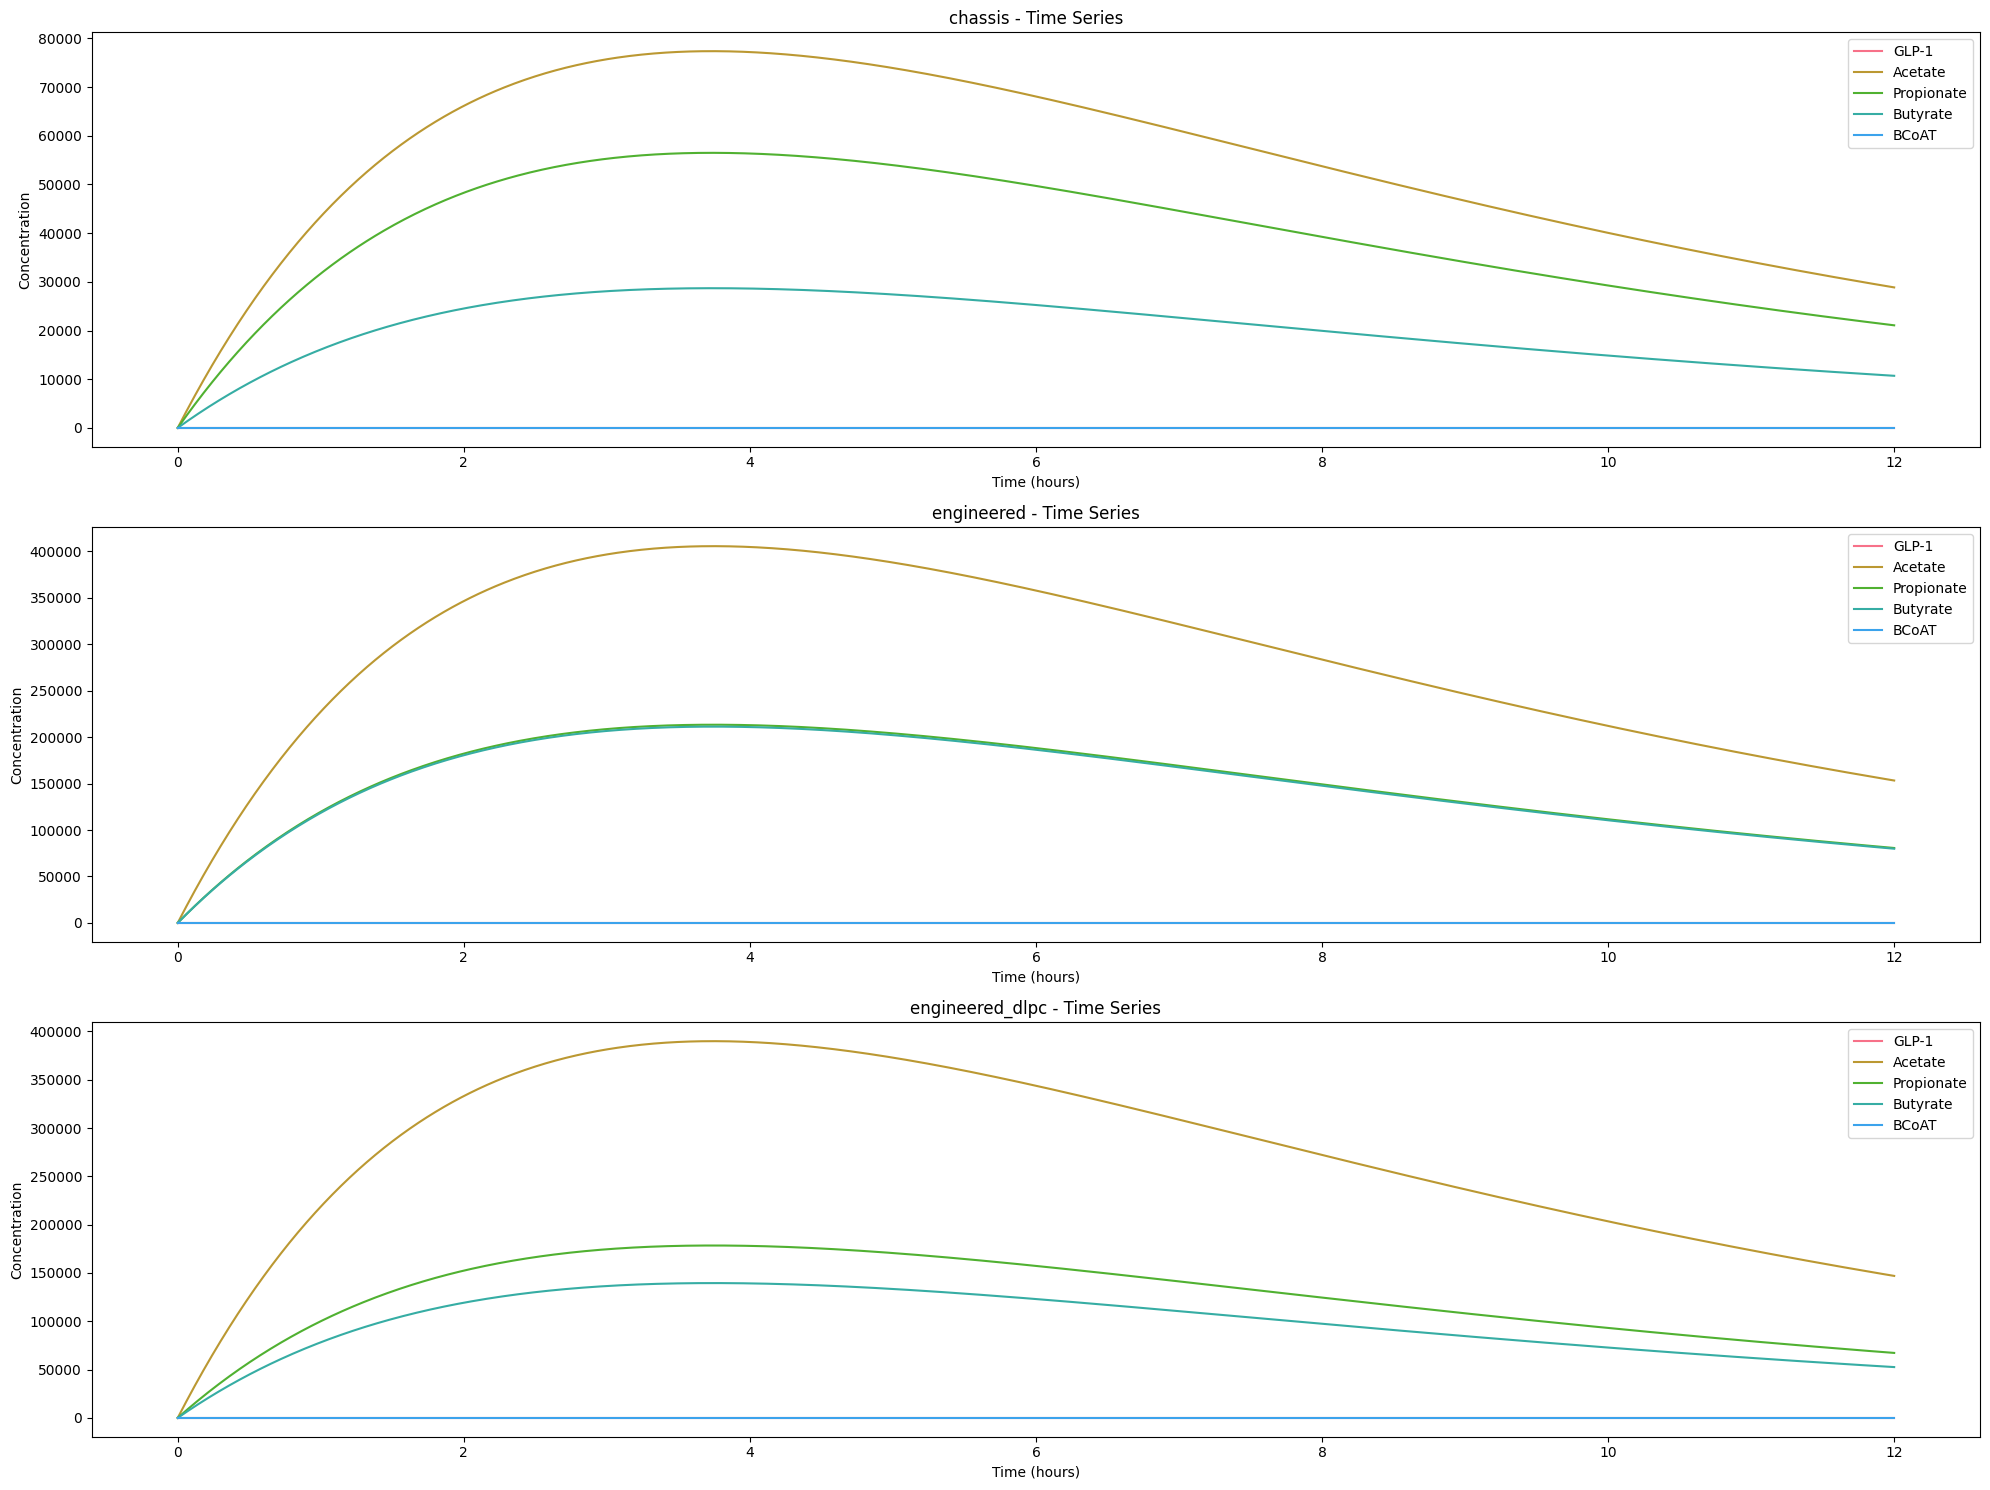

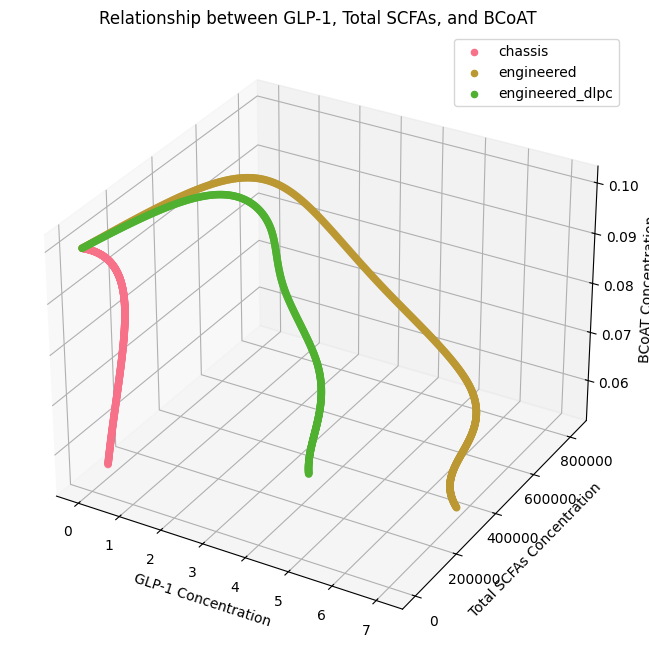

In [5]:
# 设置初始条件和时间范围
N0, Glu0, Acetate0, Propionate0, Butyrate0, E_SCFAs0, GLP10, N_DLPC0, SCFAs_DLPC0, GLP1_DLPC0, BCoAT0 = 1e6, 11.0, 0.0, 0.0, 0.0, 0.1, 0.0, 1e6, 0.0, 0.0, 0.1
y0 = [N0, Glu0, Acetate0, Propionate0, Butyrate0, E_SCFAs0, GLP10, N_DLPC0, SCFAs_DLPC0, GLP1_DLPC0, BCoAT0]
t = np.linspace(0, 12, 1000)

# 设置外部环境条件
Glu_ext, SCFAs_ext, GLP1_ext, DLPC = 11.0, 0.0, 0.0, 1.0

# 将外部环境条件添加到全局变量中
globals().update({'Glu_ext': Glu_ext, 'SCFAs_ext': SCFAs_ext, 'GLP1_ext': GLP1_ext, 'DLPC': DLPC})

# 解决ODE并绘图
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

sns.set_palette("husl")

# 1. 时间序列图
plt.figure(figsize=(20, 15))
for bacteria_type in ['chassis', 'engineered', 'engineered_dlpc']:
    solution = odeint(model, y0, t, args=(bacteria_type,))
    
    plt.subplot(3, 1, ['chassis', 'engineered', 'engineered_dlpc'].index(bacteria_type) + 1)
    plt.plot(t, solution[:, 6], label='GLP-1')
    plt.plot(t, solution[:, 2], label='Acetate')
    plt.plot(t, solution[:, 3], label='Propionate')
    plt.plot(t, solution[:, 4], label='Butyrate')
    plt.plot(t, solution[:, 10], label='BCoAT')
    plt.xlabel('Time (hours)')
    plt.ylabel('Concentration')
    plt.title(f'{bacteria_type} - Time Series')
    plt.legend()

plt.tight_layout()
plt.show()



# 3D图：GLP-1、总SCFAs和BCoAT的关系
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for bacteria_type in ['chassis', 'engineered', 'engineered_dlpc']:
    solution = odeint(model, y0, t, args=(bacteria_type,))
    total_SCFAs = solution[:, 2] + solution[:, 3] + solution[:, 4]
    ax.scatter(solution[:, 6], total_SCFAs, solution[:, 10], label=bacteria_type)

ax.set_xlabel('GLP-1 Concentration')
ax.set_ylabel('Total SCFAs Concentration')
ax.set_zlabel('BCoAT Concentration')
ax.set_title('Relationship between GLP-1, Total SCFAs, and BCoAT')
ax.legend()
plt.show()


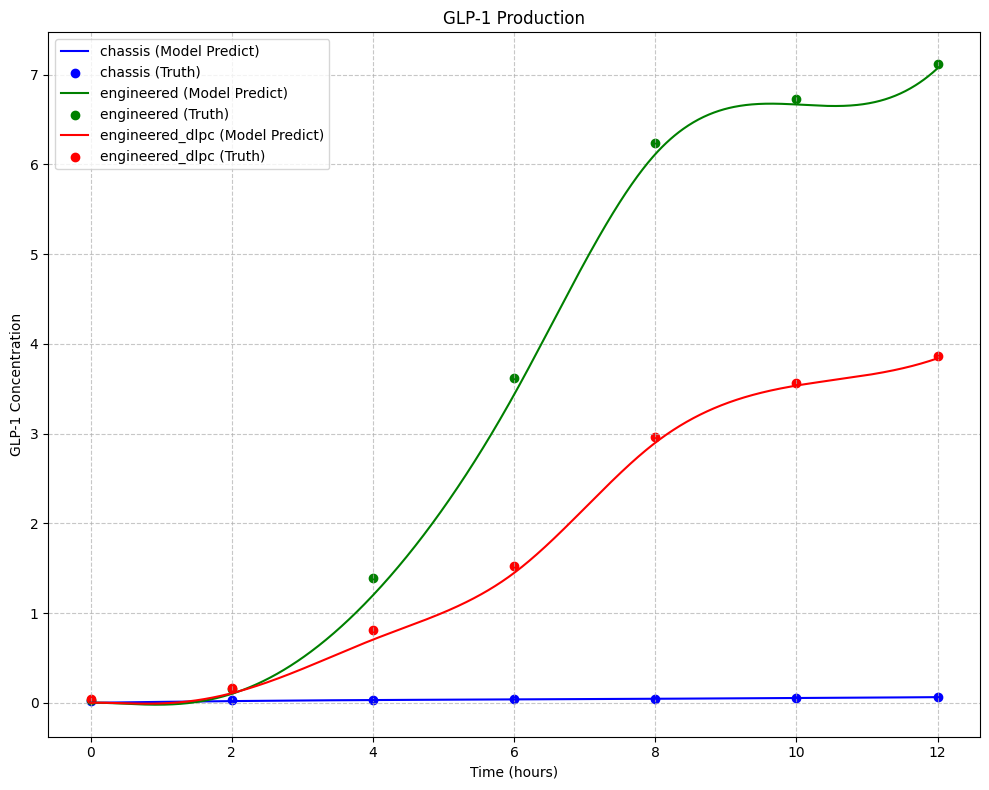

/Users/a1-6/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


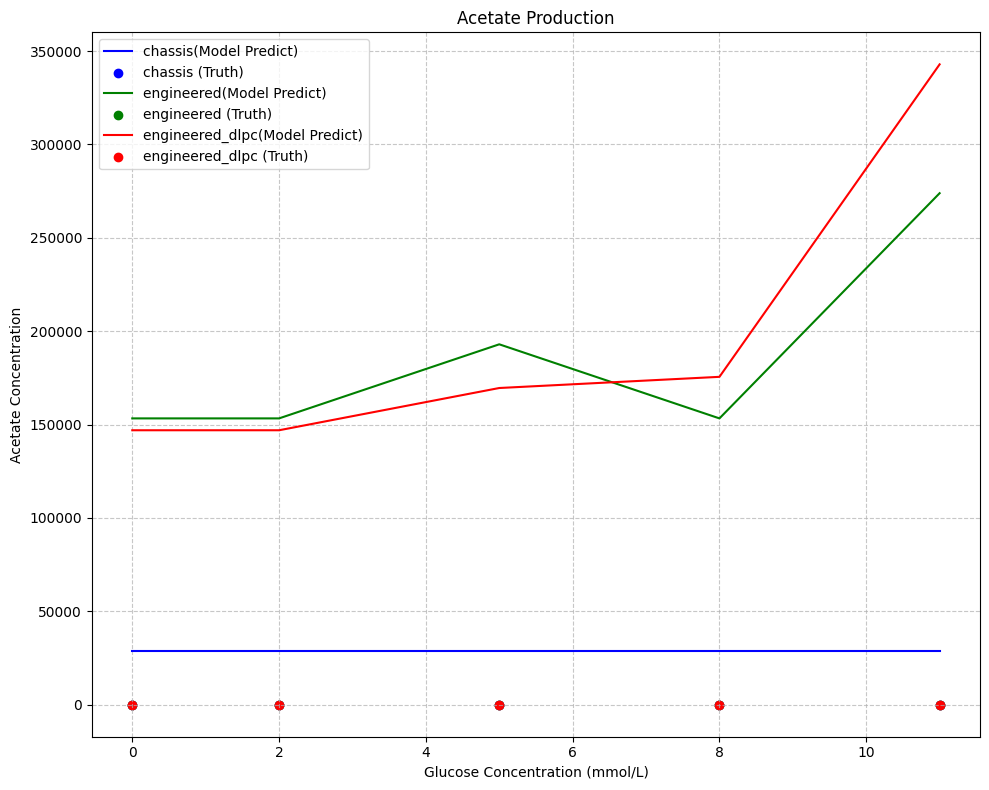

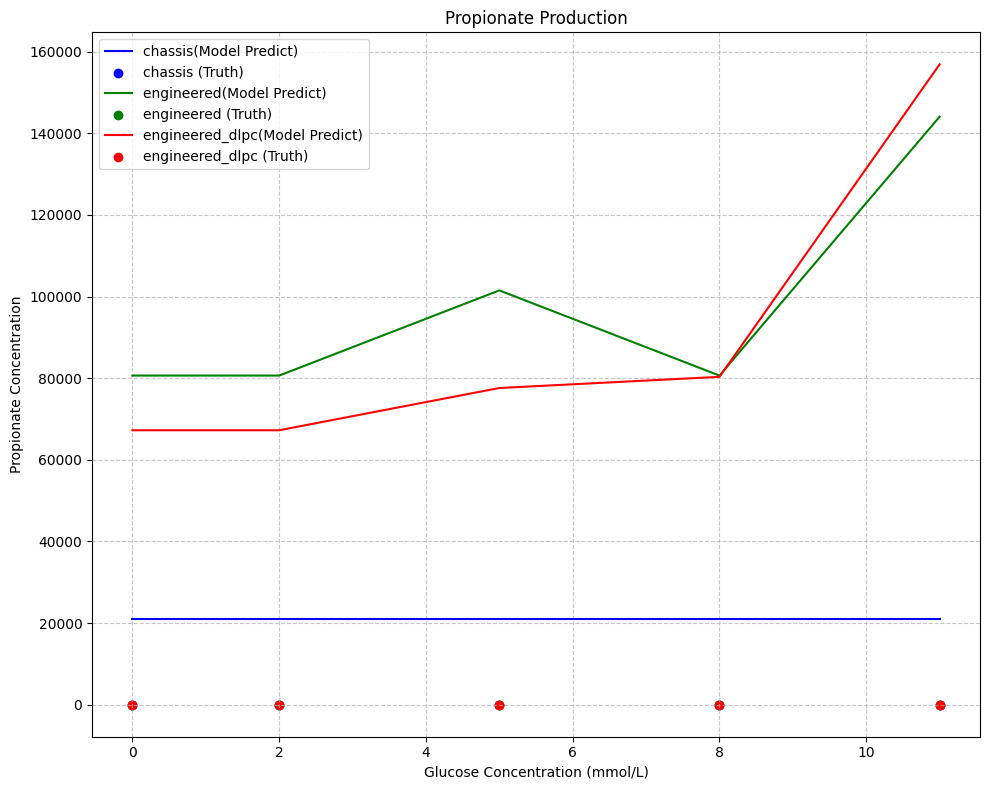

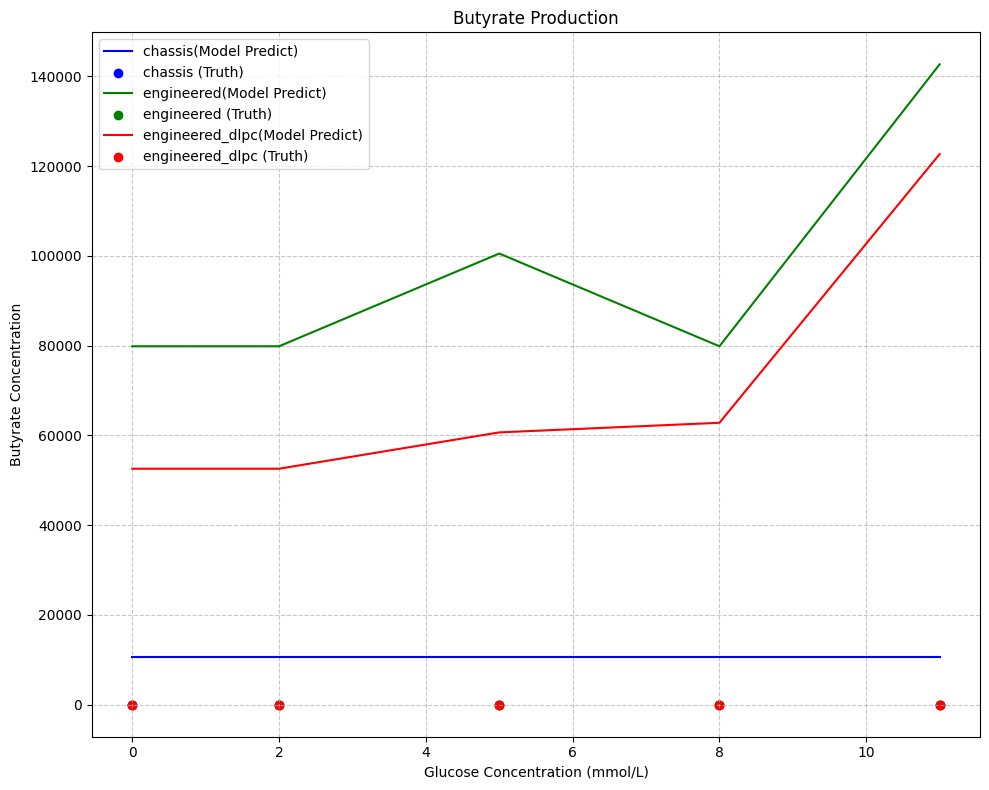

In [6]:
    import numpy as np
    from scipy.integrate import odeint
    import matplotlib.pyplot as plt


    # 初始条件和时间范围设置
    N0, Glu0, Acetate0, Propionate0, Butyrate0, E_SCFAs0, GLP10, N_DLPC0, SCFAs_DLPC0, GLP1_DLPC0, BCoAT0 = 1e6, 11.0, 0.0, 0.0, 0.0, 0.1, 0.0, 1e6, 0.0, 0.0, 0.1
    y0 = [N0, Glu0, Acetate0, Propionate0, Butyrate0, E_SCFAs0, GLP10, N_DLPC0, SCFAs_DLPC0, GLP1_DLPC0, BCoAT0]

    time_points = np.array([0, 2, 4, 6, 8, 10, 12])
    t = np.linspace(0, 12, 1000)
    glucose_concentrations = np.array([0, 2, 5, 8, 11])

    def plot_fitting(bacteria_types, data_time, data_glucose, scfa_data, model_func):
        metabolites = ['GLP-1', 'Acetate', 'Propionate', 'Butyrate']
        colors = ['b', 'g', 'r', 'c']

        for idx, metabolite in enumerate(metabolites):
            plt.figure(figsize=(10, 8))

            for bacteria_type, color in zip(bacteria_types, colors):
                if metabolite == 'GLP-1':
                    # GLP-1随时间变化
                    solution_time = odeint(model_func, y0, t, args=(bacteria_type,))
                    plt.plot(t, solution_time[:, 6], color=color, label=f'{bacteria_type} (Model Predict)')
                    plt.scatter(time_points, data_time[bacteria_type], color=color, marker='o', label=f'{bacteria_type} (Truth)')
                    plt.xlabel('Time (hours)')
                else:
                    # SCFAs随葡萄糖浓度变化
                    scfa_index = ['Acetate', 'Propionate', 'Butyrate'].index(metabolite) + 2
                    scfa_concentrations = []
                    for glu in glucose_concentrations:
                        y0_glu = y0.copy()
                        y0_glu[1] = glu  # 设置初始葡萄糖浓度
                        solution = odeint(model_func, y0_glu, [0, 12], args=(bacteria_type,))
                        scfa_concentrations.append(solution[-1, scfa_index])

                    plt.plot(glucose_concentrations, scfa_concentrations, color=color, label=f'{bacteria_type}(Model Predict)')
                    plt.scatter(glucose_concentrations, scfa_data[metabolite.lower()][bacteria_type], color=color, marker='o', label=f'{bacteria_type} (Truth)')
                    plt.xlabel('Glucose Concentration (mmol/L)')

            plt.ylabel(f'{metabolite} Concentration')
            plt.title(f'{metabolite} Production')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

    # 调用绘图函数
    plot_fitting(['chassis', 'engineered', 'engineered_dlpc'], glp1_data_time, glp1_data_glucose, scfa_data, model)

In [7]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 实验数据
time_points = np.array([0, 2, 4, 6, 8, 10, 12])
glp1_data_time = {
    'chassis': np.array([
        [0.031, 0.03, 0.039, 0.037, 0.052, 0.045, 0.078],
        [0.018, 0.025, 0.036, 0.041, 0.044, 0.061, 0.076],
        [0.022, 0.036, 0.033, 0.04, 0.042, 0.055, 0.037]
    ]),
    'engineered': np.array([
        [0.033, 0.122, 1.278, 3.296, 6.172, 6.828, 7.105],
        [0.025, 0.136, 1.369, 4.014, 6.565, 6.751, 7.331],
        [0.047, 0.217, 1.515, 3.552, 5.987, 6.609, 6.909]
    ]),
    'engineered_dlpc': np.array([
        [0.044, 0.198, 0.889, 1.491, 2.814, 3.582, 3.8],
        [0.058, 0.105, 0.765, 1.552, 3.01, 3.711, 4.001],
        [0.03, 0.206, 0.792, 1.535, 3.053, 3.412, 3.786]
    ])
}

# 创建插值函数
def create_interpolation(data):
    return [interp1d(time_points, d, kind='cubic', fill_value='extrapolate') for d in data]

chassis_interp = create_interpolation(glp1_data_time['chassis'])
engineered_interp = create_interpolation(glp1_data_time['engineered'])
engineered_dlpc_interp = create_interpolation(glp1_data_time['engineered_dlpc'])


# 定义稳态方程组
def steady_state_equations(vars):
    N, Glu, SCFAs, E_SCFAs, GLP1, BCoAT = vars
    
    if DLPC == 1.0:
        GLP1_target = np.mean([f(12) for f in engineered_dlpc_interp])
    else:
        GLP1_target = np.mean([f(12) for f in engineered_interp])
    
    eq1 = r*N*(1 - N/K) - mu*N - beta*SCFAs*N/(K_s + SCFAs) + gamma*GLP1*N/(K_p + GLP1) - delta*DLPC*N
    eq2 = -k_uptake*N*Glu/(K_p + Glu) + D_Glu*(Glu_ext - Glu)
    eq3 = V_max*E_SCFAs*N*Glu/(K_m + Glu) - k_deg*SCFAs - D_SCFAs*(SCFAs - SCFAs_ext)
    eq4 = a_SCFAs*BCoAT*Glu/(K_SCFAs + Glu) - lambda_E*E_SCFAs
    eq5 = nu_max*(GLP1_target - GLP1)*BCoAT/(K_p + BCoAT)*N - delta_GLP*GLP1 - epsilon*GLP1*N - D_GLP*(GLP1 - GLP1_ext)
    eq6 = k_BCoAT*Glu/(K_p + Glu) * 1/(1 + SCFAs/K_inh) - k_BCoAT_deg*BCoAT
    
    return [eq1, eq2, eq3, eq4, eq5, eq6]

# 求解稳态
initial_guess = [1e8, 5.0, 1.0, 0.5, 2.0, 0.5]  # 初始猜测值
solution = optimize.root(steady_state_equations, initial_guess, method='hybr')

if solution.success:
    N_ss, Glu_ss, SCFAs_ss, E_SCFAs_ss, GLP1_ss, BCoAT_ss = solution.x
    print("稳态解:")
    print(f"N = {N_ss:.2e}")
    print(f"Glu = {Glu_ss:.4f}")
    print(f"SCFAs = {SCFAs_ss:.4f}")
    print(f"E_SCFAs = {E_SCFAs_ss:.4f}")
    print(f"GLP1 = {GLP1_ss:.4f}")
    print(f"BCoAT = {BCoAT_ss:.4f}")
else:
    print("未能找到稳态解")

稳态解:
N = -1.21e-11
Glu = 11.0000
SCFAs = -0.0000
E_SCFAs = 2.5208
GLP1 = -0.0000
BCoAT = 1.8333


In [8]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 实验数据
time_points = np.array([0, 2, 4, 6, 8, 10, 12])
glp1_data_time = {
    'chassis': np.array([
        [0.031, 0.03, 0.039, 0.037, 0.052, 0.045, 0.078],
        [0.018, 0.025, 0.036, 0.041, 0.044, 0.061, 0.076],
        [0.022, 0.036, 0.033, 0.04, 0.042, 0.055, 0.037]
    ]),
    'engineered': np.array([
        [0.033, 0.122, 1.278, 3.296, 6.172, 6.828, 7.105],
        [0.025, 0.136, 1.369, 4.014, 6.565, 6.751, 7.331],
        [0.047, 0.217, 1.515, 3.552, 5.987, 6.609, 6.909]
    ]),
    'engineered_dlpc': np.array([
        [0.044, 0.198, 0.889, 1.491, 2.814, 3.582, 3.8],
        [0.058, 0.105, 0.765, 1.552, 3.01, 3.711, 4.001],
        [0.03, 0.206, 0.792, 1.535, 3.053, 3.412, 3.786]
    ])
}

# 创建插值函数
def create_interpolation(data):
    return [interp1d(time_points, d, kind='cubic', fill_value='extrapolate') for d in data]

chassis_interp = create_interpolation(glp1_data_time['chassis'])
engineered_interp = create_interpolation(glp1_data_time['engineered'])
engineered_dlpc_interp = create_interpolation(glp1_data_time['engineered_dlpc'])


# 定义稳态方程组
def steady_state_equations(vars, strain):
    N, Glu, SCFAs, E_SCFAs, GLP1, BCoAT = vars
    
    if strain == 'chassis':
        GLP1_target = np.mean([f(12) for f in chassis_interp])
        DLPC = 0.0
    elif strain == 'engineered':
        GLP1_target = np.mean([f(12) for f in engineered_interp])
        DLPC = 0.0
    else:  # engineered_dlpc
        GLP1_target = np.mean([f(12) for f in engineered_dlpc_interp])
        DLPC = 1.0
    
    eq1 = r*N*(1 - N/K) - mu*N - beta*SCFAs*N/(K_s + SCFAs) + gamma*GLP1*N/(K_p + GLP1) - delta*DLPC*N
    eq2 = -k_uptake*N*Glu/(K_p + Glu) + D_Glu*(Glu_ext - Glu)
    eq3 = V_max*E_SCFAs*N*Glu/(K_m + Glu) - k_deg*SCFAs - D_SCFAs*(SCFAs - SCFAs_ext)
    eq4 = a_SCFAs*BCoAT*Glu/(K_SCFAs + Glu) - lambda_E*E_SCFAs
    eq5 = nu_max*(GLP1_target - GLP1)*BCoAT/(K_p + BCoAT)*N - delta_GLP*GLP1 - epsilon*GLP1*N - D_GLP*(GLP1 - GLP1_ext)
    eq6 = k_BCoAT*Glu/(K_p + Glu) * 1/(1 + SCFAs/K_inh) - k_BCoAT_deg*BCoAT
    
    return [eq1, eq2, eq3, eq4, eq5, eq6]

def jacobian(vars, strain):
    N, Glu, SCFAs, E_SCFAs, GLP1, BCoAT = vars
    
    if strain == 'chassis':
        GLP1_target = np.mean([f(12) for f in chassis_interp])
        DLPC = 0.0
    elif strain == 'engineered':
        GLP1_target = np.mean([f(12) for f in engineered_interp])
        DLPC = 0.0
    else:  # engineered_dlpc
        GLP1_target = np.mean([f(12) for f in engineered_dlpc_interp])
        DLPC = 1.0
    
    J = np.zeros((6, 6))
    
    J[0][0] = r*(1 - 2*N/K) - mu - beta*SCFAs/(K_s + SCFAs) + gamma*GLP1/(K_p + GLP1) - delta*DLPC
    J[0][2] = -beta*N*K_s / (K_s + SCFAs)**2
    J[0][4] = gamma*N*K_p / (K_p + GLP1)**2

    J[1][0] = -k_uptake*Glu/(K_p + Glu)
    J[1][1] = -k_uptake*N*K_p/(K_p + Glu)**2 - D_Glu

    J[2][0] = V_max*E_SCFAs*Glu/(K_m + Glu)
    J[2][1] = V_max*E_SCFAs*N*K_m/(K_m + Glu)**2
    J[2][2] = -k_deg - D_SCFAs
    J[2][3] = V_max*N*Glu/(K_m + Glu)

    J[3][1] = a_SCFAs*BCoAT*K_SCFAs/(K_SCFAs + Glu)**2
    J[3][3] = -lambda_E
    J[3][5] = a_SCFAs*Glu/(K_SCFAs + Glu)

    J[4][0] = nu_max*(GLP1_target - GLP1)*BCoAT/(K_p + BCoAT) - epsilon*GLP1
    J[4][4] = -nu_max*N*BCoAT/(K_p + BCoAT) - delta_GLP - epsilon*N - D_GLP
    J[4][5] = nu_max*N*(GLP1_target - GLP1)*K_p/(K_p + BCoAT)**2

    J[5][1] = k_BCoAT*K_p/(K_p + Glu)**2 * 1/(1 + SCFAs/K_inh)
    J[5][2] = -k_BCoAT*Glu/(K_p + Glu) * 1/K_inh/(1 + SCFAs/K_inh)**2
    J[5][5] = -k_BCoAT_deg
    
    return J

# 求解稳态
initial_guess = [1e8, 1.0, 1.0, 0.5, 2.0, 0.5]  # 初始猜测值

for strain in ['chassis', 'engineered', 'engineered_dlpc']:
    print(f"\n计算 {strain} 的稳态解:")
    solution = optimize.root(steady_state_equations, initial_guess, args=(strain,), method='hybr')

    if solution.success:
        N_ss, Glu_ss, SCFAs_ss, E_SCFAs_ss, GLP1_ss, BCoAT_ss = solution.x
        print("稳态解:")
        print(f"N = {N_ss:.2e}")
        print(f"Glu = {Glu_ss:.4f}")
        print(f"SCFAs = {SCFAs_ss:.4f}")
        print(f"E_SCFAs = {E_SCFAs_ss:.4f}")
        print(f"GLP1 = {GLP1_ss:.4f}")
        print(f"BCoAT = {BCoAT_ss:.4f}")

        # 计算Jacobian矩阵
        J = jacobian(solution.x, strain)
        
        # 计算特征值
        eigenvalues = np.linalg.eigvals(J)
        
        print("\n特征值:")
        for ev in eigenvalues:
            print(f"{ev.real:.4f} + {ev.imag:.4f}j")
        
        # 判断稳定性
        if all(ev.real < 0 for ev in eigenvalues):
            print("\n该稳态是稳定的。")
        else:
            print("\n该稳态是不稳定的。")
    else:
        print(f"未能找到 {strain} 的稳态解")


计算 chassis 的稳态解:
未能找到 chassis 的稳态解

计算 engineered 的稳态解:
未能找到 engineered 的稳态解

计算 engineered_dlpc 的稳态解:
未能找到 engineered_dlpc 的稳态解


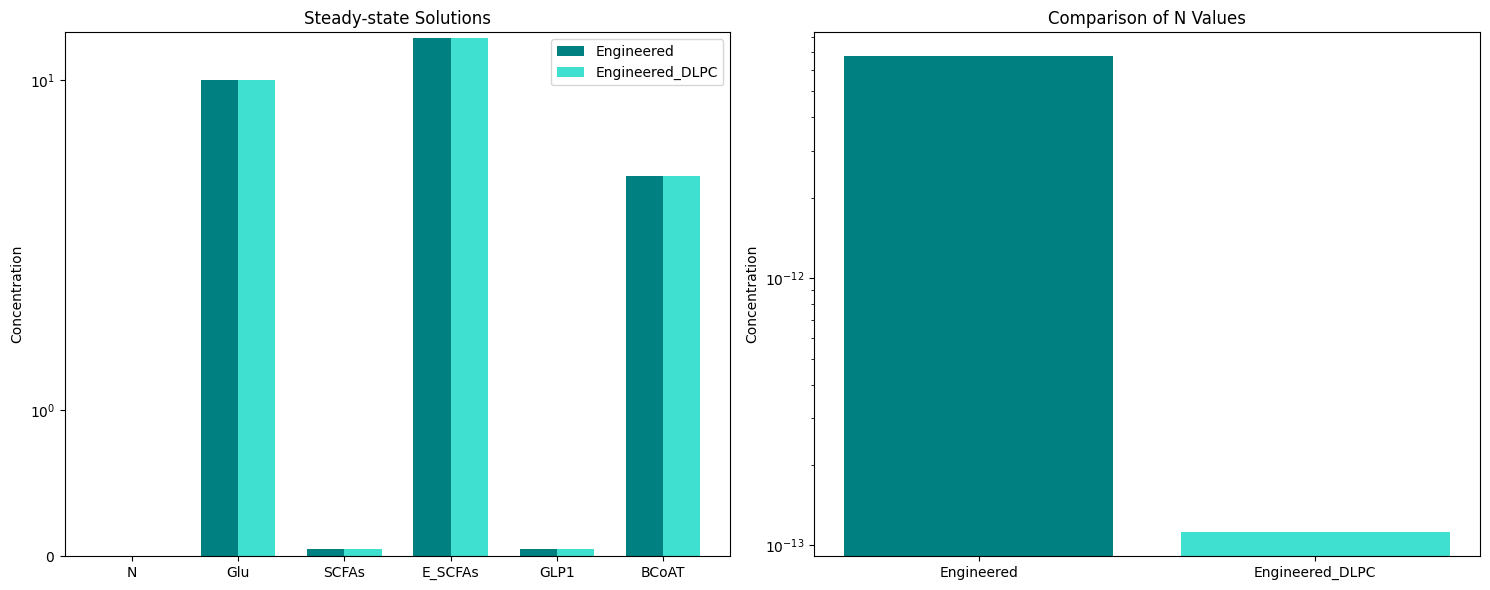

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 定义数据
strains = ['Engineered', 'Engineered_DLPC']
N_values = [6.78e-12, 1.12e-13]
Glu_values = [10.0000, 10.0000]
SCFAs_values = [0.0500, 0.0500]
E_SCFAs_values = [14.4300, 14.4300]
GLP1_values = [0.0500, 0.0500]
BCoAT_values = [4.3290, 4.3290]

# 创建图形和子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 绘制稳态值的条形图
variables = ['N', 'Glu', 'SCFAs', 'E_SCFAs', 'GLP1', 'BCoAT']
x = np.arange(len(variables))
width = 0.35

# 使用蓝绿色
ax1.bar(x - width/2, [N_values[0], Glu_values[0], SCFAs_values[0], E_SCFAs_values[0], GLP1_values[0], BCoAT_values[0]], width, label='Engineered', color='teal')
ax1.bar(x + width/2, [N_values[1], Glu_values[1], SCFAs_values[1], E_SCFAs_values[1], GLP1_values[1], BCoAT_values[1]], width, label='Engineered_DLPC', color='turquoise')

ax1.set_ylabel('Concentration')
ax1.set_title('Steady-state Solutions')
ax1.set_xticks(x)
ax1.set_xticklabels(variables)
ax1.legend()
ax1.set_yscale('symlog')

# 绘制N值的比较图
ax2.bar(strains, N_values, color=['teal', 'turquoise'])
ax2.set_title('Comparison of N Values')
ax2.set_ylabel('Concentration')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

/Users/a1-6/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/a1-6/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


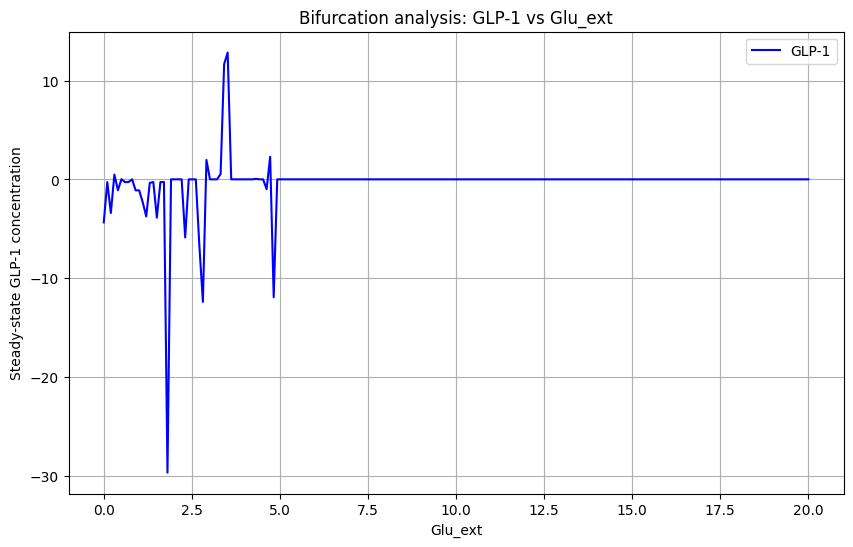

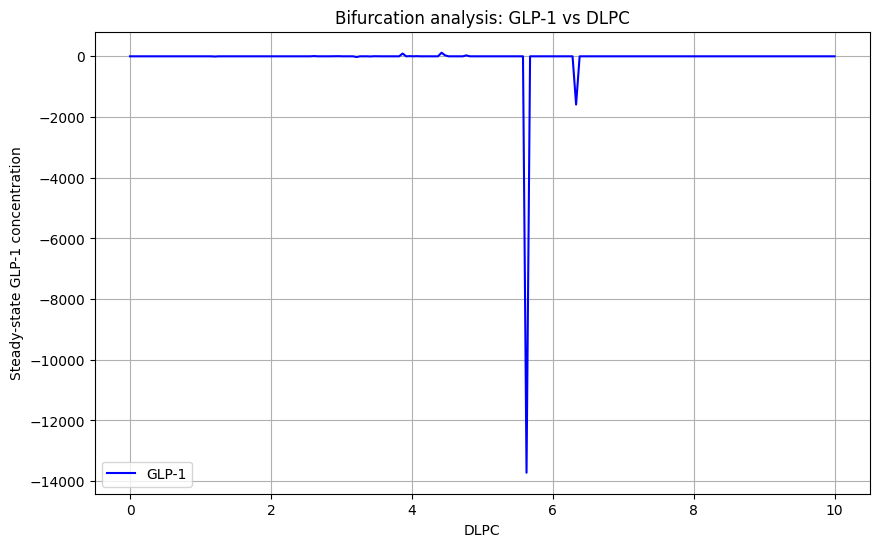

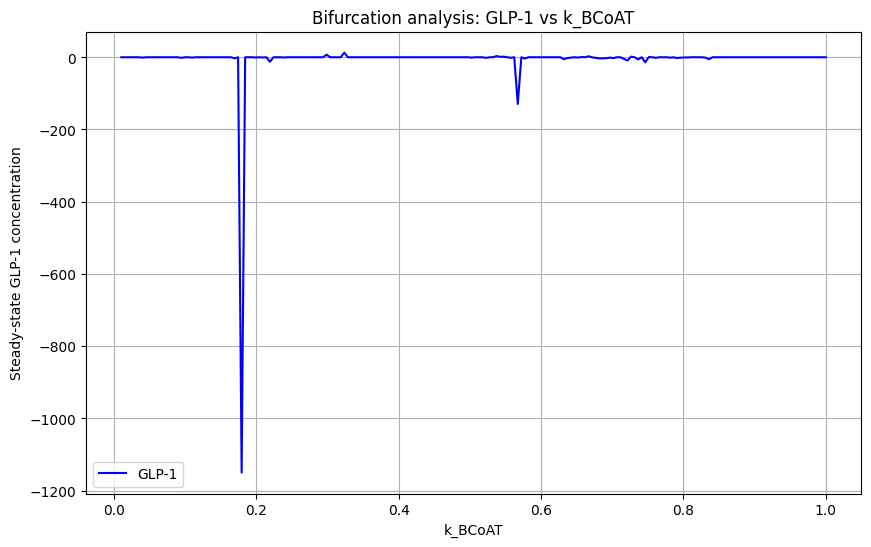

In [10]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


# 创建 GLP1 插值函数
time_points = [0, 2, 4, 6, 8, 10, 12]
glp1_values = [0, 0.2, 0.5, 0.8, 1.0, 1.1, 1.2]
glucose_points = [0, 2, 5, 8, 11]
glp1_glucose_values = [0, 0.3, 0.7, 0.9, 1.0]

glp1_interp_time = interp1d(time_points, glp1_values, kind='cubic', fill_value='extrapolate')
glp1_interp_glucose = interp1d(glucose_points, glp1_glucose_values, kind='cubic', fill_value='extrapolate')

# 定义模型函数
def model(vars, t, Glu_ext, DLPC, k_BCoAT):
    N, Glu, SCFAs, E_SCFAs, GLP1, BCoAT = vars
    
    # GLP1 目标值计算
    GLP1_target_time = glp1_interp_time(t)
    GLP1_target_glucose = glp1_interp_glucose(Glu)
    GLP1_target = (GLP1_target_time * (1 - np.exp(-lambda_nu * t)) + 
                   GLP1_target_glucose * (Glu**2 / (K_p**2 + Glu**2)))
    
    dNdt = r*N*(1 - N/K) - mu*N - beta*SCFAs*N/(K_s + SCFAs) + gamma*GLP1*N/(K_p + GLP1) - delta*DLPC*N
    dGludt = -k_uptake*N*Glu/(K_p + Glu) + D_Glu*(Glu_ext - Glu)
    dSCFAsdt = V_max*E_SCFAs*N*Glu/(K_m + Glu) - k_deg*SCFAs - D_SCFAs*(SCFAs - SCFAs_ext)
    dE_SCFAsdt = a_SCFAs*BCoAT*Glu/(K_SCFAs + Glu) - lambda_E*E_SCFAs
    dGLP1dt = nu_max*(GLP1_target - GLP1)*BCoAT/(K_p + BCoAT)*N - delta_GLP*GLP1 - epsilon*GLP1*N - D_GLP*(GLP1 - GLP1_ext)
    dBCoATdt = k_BCoAT*Glu/(K_p + Glu) * 1/(1 + SCFAs/K_inh) - k_BCoAT_deg*BCoAT
    
    return [dNdt, dGludt, dSCFAsdt, dE_SCFAsdt, dGLP1dt, dBCoATdt]

# 定义稳态求解函数
def steady_state(Glu_ext, DLPC, k_BCoAT):
    def equations(vars):
        return model(vars, 0, Glu_ext, DLPC, k_BCoAT)
    
    initial_guess = [1e6, 5.0, 1.0, 0.1, 0.1, 0.1]
    solution = optimize.fsolve(equations, initial_guess)
    return solution

# 进行分岔分析
def bifurcation_analysis(param_range, param_name, fixed_params):
    steady_states = []

    for param_value in param_range:
        if param_name == 'Glu_ext':
            Glu_ext = param_value
            DLPC, k_BCoAT = fixed_params
        elif param_name == 'DLPC':
            DLPC = param_value
            Glu_ext, k_BCoAT = fixed_params
        elif param_name == 'k_BCoAT':
            k_BCoAT = param_value
            Glu_ext, DLPC = fixed_params
        
        ss = steady_state(Glu_ext, DLPC, k_BCoAT)
        steady_states.append(ss)

    steady_states = np.array(steady_states)

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, steady_states[:, 4], 'b-', label='GLP-1')
    plt.xlabel(f'{param_name}')
    plt.ylabel('Steady-state GLP-1 concentration')
    plt.title(f'Bifurcation analysis: GLP-1 vs {param_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# 分岔分析参数范围
Glu_ext_range = np.linspace(0, 20, 200)
DLPC_range = np.linspace(0, 10, 200)
k_BCoAT_range = np.linspace(0.01, 1, 200)

# 固定参数
fixed_params_Glu_ext = (1.0, 0.1)  # 固定DLPC和k_BCoAT
fixed_params_DLPC = (10.0, 0.1)    # 固定Glu_ext和k_BCoAT
fixed_params_k_BCoAT = (10.0, 1.0) # 固定Glu_ext和DLPC

# 进行分岔分析
bifurcation_analysis(Glu_ext_range, 'Glu_ext', fixed_params_Glu_ext)
bifurcation_analysis(DLPC_range, 'DLPC', fixed_params_DLPC)
bifurcation_analysis(k_BCoAT_range, 'k_BCoAT', fixed_params_k_BCoAT)

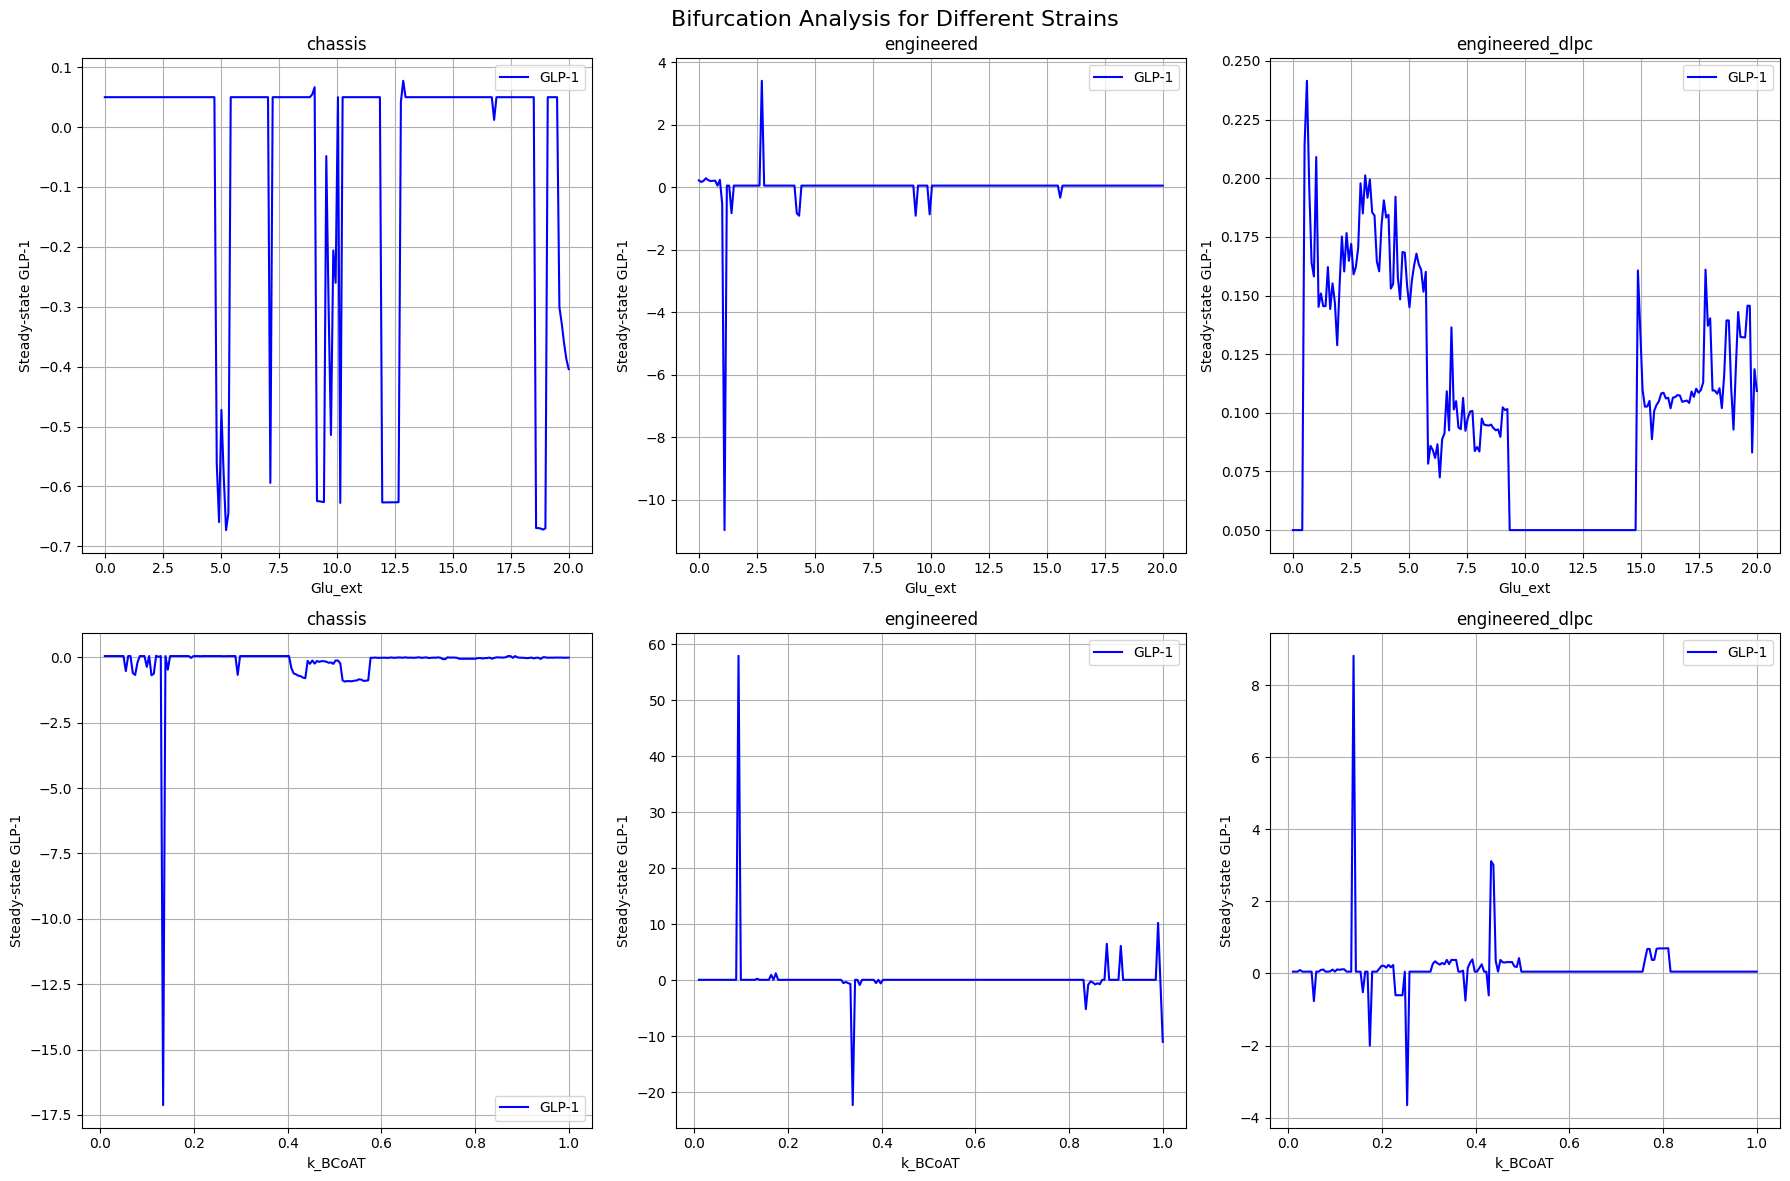

In [11]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 实验数据
time_points = np.array([0, 2, 4, 6, 8, 10, 12])
glp1_data_time = {
    'chassis': np.array([
        [0.031, 0.03, 0.039, 0.037, 0.052, 0.045, 0.078],
        [0.018, 0.025, 0.036, 0.041, 0.044, 0.061, 0.076],
        [0.022, 0.036, 0.033, 0.04, 0.042, 0.055, 0.037]
    ]),
    'engineered': np.array([
        [0.033, 0.122, 1.278, 3.296, 6.172, 6.828, 7.105],
        [0.025, 0.136, 1.369, 4.014, 6.565, 6.751, 7.331],
        [0.047, 0.217, 1.515, 3.552, 5.987, 6.609, 6.909]
    ]),
    'engineered_dlpc': np.array([
        [0.044, 0.198, 0.889, 1.491, 2.814, 3.582, 3.8],
        [0.058, 0.105, 0.765, 1.552, 3.01, 3.711, 4.001],
        [0.03, 0.206, 0.792, 1.535, 3.053, 3.412, 3.786]
    ])
}

# 创建插值函数
def create_interpolation(data):
    return [interp1d(time_points, d, kind='cubic', fill_value='extrapolate') for d in data]

chassis_interp = create_interpolation(glp1_data_time['chassis'])
engineered_interp = create_interpolation(glp1_data_time['engineered'])
engineered_dlpc_interp = create_interpolation(glp1_data_time['engineered_dlpc'])

# 定义模型参数
r, K, mu, beta, K_s, gamma, K_p, delta = 0.5, 1e9, 0.1, 0.2, 1.0, 0.1, 1.0, 0.05
k_uptake, D_Glu, Glu_ext, V_max, K_m, k_deg, D_SCFAs, SCFAs_ext = 0.1, 0.1, 10.0, 0.5, 1.0, 0.1, 0.1, 0.1
a_SCFAs, K_SCFAs, lambda_E, nu_max, delta_GLP, epsilon, D_GLP, GLP1_ext = 0.5, 1.0, 0.1, 0.5, 0.1, 0.05, 0.1, 0.1
k_BCoAT, K_inh, k_BCoAT_deg = 0.5, 1.0, 0.1

# 定义稳态方程组
def steady_state_equations(vars, strain, Glu_ext, k_BCoAT):
    N, Glu, SCFAs, E_SCFAs, GLP1, BCoAT = vars
    
    if strain == 'chassis':
        GLP1_target = np.mean([f(12) for f in chassis_interp])
        DLPC = 0.0
    elif strain == 'engineered':
        GLP1_target = np.mean([f(12) for f in engineered_interp])
        DLPC = 0.0
    else:  # engineered_dlpc
        GLP1_target = np.mean([f(12) for f in engineered_dlpc_interp])
        DLPC = 1.0
    
    eq1 = r*N*(1 - N/K) - mu*N - beta*SCFAs*N/(K_s + SCFAs) + gamma*GLP1*N/(K_p + GLP1) - delta*DLPC*N
    eq2 = -k_uptake*N*Glu/(K_p + Glu) + D_Glu*(Glu_ext - Glu)
    eq3 = V_max*E_SCFAs*N*Glu/(K_m + Glu) - k_deg*SCFAs - D_SCFAs*(SCFAs - SCFAs_ext)
    eq4 = a_SCFAs*BCoAT*Glu/(K_SCFAs + Glu) - lambda_E*E_SCFAs
    eq5 = nu_max*(GLP1_target - GLP1)*BCoAT/(K_p + BCoAT)*N - delta_GLP*GLP1 - epsilon*GLP1*N - D_GLP*(GLP1 - GLP1_ext)
    eq6 = k_BCoAT*Glu/(K_p + Glu) * 1/(1 + SCFAs/K_inh) - k_BCoAT_deg*BCoAT
    
    return [eq1, eq2, eq3, eq4, eq5, eq6]

# 定义稳态求解函数
def steady_state(strain, Glu_ext, k_BCoAT):
    def equations(vars):
        return steady_state_equations(vars, strain, Glu_ext, k_BCoAT)
    
    initial_guess = [1e6, 5.0, 1.0, 0.1, 0.1, 0.1]
    solution = optimize.fsolve(equations, initial_guess)
    return solution

# 进行分岔分析
def bifurcation_analysis(param_range, param_name, strain, fixed_params, ax):
    steady_states = []

    for param_value in param_range:
        if param_name == 'Glu_ext':
            Glu_ext = param_value
            k_BCoAT = fixed_params[0]
        elif param_name == 'k_BCoAT':
            k_BCoAT = param_value
            Glu_ext = fixed_params[0]
        
        ss = steady_state(strain, Glu_ext, k_BCoAT)
        steady_states.append(ss)

    steady_states = np.array(steady_states)

    ax.plot(param_range, steady_states[:, 4], 'b-', label='GLP-1')
    ax.set_xlabel(f'{param_name}')
    ax.set_ylabel('Steady-state GLP-1')
    ax.set_title(f'{strain}')
    ax.legend()
    ax.grid(True)

# 分岔分析参数范围
Glu_ext_range = np.linspace(0, 20, 200)
k_BCoAT_range = np.linspace(0.01, 1, 200)

# 固定参数
fixed_params_Glu_ext = (0.1,)  # 固定k_BCoAT
fixed_params_k_BCoAT = (10.0,) # 固定Glu_ext

# 创建 2*3 的图表
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Bifurcation Analysis for Different Strains', fontsize=16)

strains = ['chassis', 'engineered', 'engineered_dlpc']

for i, strain in enumerate(strains):
    # Glu_ext 分岔分析
    bifurcation_analysis(Glu_ext_range, 'Glu_ext', strain, fixed_params_Glu_ext, axs[0, i])
    
    # k_BCoAT 分岔分析
    bifurcation_analysis(k_BCoAT_range, 'k_BCoAT', strain, fixed_params_k_BCoAT, axs[1, i])

plt.tight_layout()
plt.show()

/var/folders/2f/5hbxxz8n7xg10l145zyht4nm0000gn/T/ipykernel_51288/2830339485.py:101: RuntimeWarning: invalid value encountered in log
  log_sensitivity = np.log(GLP1_ss_new / GLP1_ss) / np.log((param_new) / param_value)


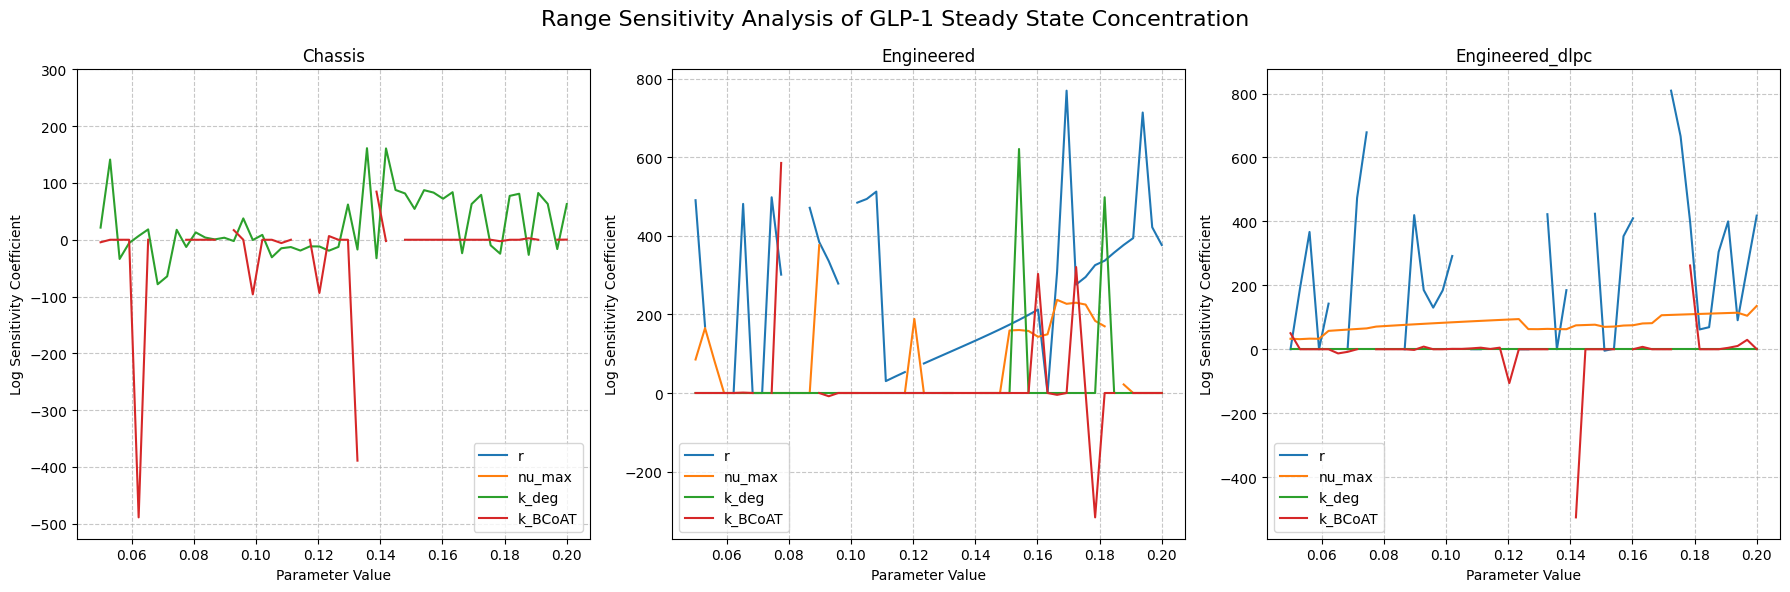

In [12]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 实验数据
time_points = np.array([0, 2, 4, 6, 8, 10, 12])
glp1_data_time = {
    'chassis': np.array([
        [0.031, 0.03, 0.039, 0.037, 0.052, 0.045, 0.078],
        [0.018, 0.025, 0.036, 0.041, 0.044, 0.061, 0.076],
        [0.022, 0.036, 0.033, 0.04, 0.042, 0.055, 0.037]
    ]),
    'engineered': np.array([
        [0.033, 0.122, 1.278, 3.296, 6.172, 6.828, 7.105],
        [0.025, 0.136, 1.369, 4.014, 6.565, 6.751, 7.331],
        [0.047, 0.217, 1.515, 3.552, 5.987, 6.609, 6.909]
    ]),
    'engineered_dlpc': np.array([
        [0.044, 0.198, 0.889, 1.491, 2.814, 3.582, 3.8],
        [0.058, 0.105, 0.765, 1.552, 3.01, 3.711, 4.001],
        [0.03, 0.206, 0.792, 1.535, 3.053, 3.412, 3.786]
    ])
}

# 创建插值函数
def create_interpolation(data):
    return [interp1d(time_points, d, kind='cubic', fill_value='extrapolate') for d in data]

chassis_interp = create_interpolation(glp1_data_time['chassis'])
engineered_interp = create_interpolation(glp1_data_time['engineered'])
engineered_dlpc_interp = create_interpolation(glp1_data_time['engineered_dlpc'])

# 定义模型参数
r, K, mu, beta, K_s, gamma, K_p, delta = 0.5, 1e9, 0.1, 0.2, 1.0, 0.1, 1.0, 0.05
k_uptake, D_Glu, Glu_ext, V_max, K_m, k_deg, D_SCFAs, SCFAs_ext = 0.1, 0.1, 10.0, 0.5, 1.0, 0.1, 0.1, 0.1
a_SCFAs, K_SCFAs, lambda_E, nu_max, delta_GLP, epsilon, D_GLP, GLP1_ext = 0.5, 1.0, 0.1, 0.5, 0.1, 0.05, 0.1, 0.1
k_BCoAT, K_inh, k_BCoAT_deg = 0.5, 1.0, 0.1

# 定义稳态方程组
def steady_state_equations(vars, strain, Glu_ext, k_BCoAT):
    N, Glu, SCFAs, E_SCFAs, GLP1, BCoAT = vars
    
    if strain == 'chassis':
        GLP1_target = np.mean([f(12) for f in chassis_interp])
        DLPC = 0.0
    elif strain == 'engineered':
        GLP1_target = np.mean([f(12) for f in engineered_interp])
        DLPC = 0.0
    else:  # engineered_dlpc
        GLP1_target = np.mean([f(12) for f in engineered_dlpc_interp])
        DLPC = 1.0
    
    eq1 = r*N*(1 - N/K) - mu*N - beta*SCFAs*N/(K_s + SCFAs) + gamma*GLP1*N/(K_p + GLP1) - delta*DLPC*N
    eq2 = -k_uptake*N*Glu/(K_p + Glu) + D_Glu*(Glu_ext - Glu)
    eq3 = V_max*E_SCFAs*N*Glu/(K_m + Glu) - k_deg*SCFAs - D_SCFAs*(SCFAs - SCFAs_ext)
    eq4 = a_SCFAs*BCoAT*Glu/(K_SCFAs + Glu) - lambda_E*E_SCFAs
    eq5 = nu_max*(GLP1_target - GLP1)*BCoAT/(K_p + BCoAT)*N - delta_GLP*GLP1 - epsilon*GLP1*N - D_GLP*(GLP1 - GLP1_ext)
    eq6 = k_BCoAT*Glu/(K_p + Glu) * 1/(1 + SCFAs/K_inh) - k_BCoAT_deg*BCoAT
    
    return [eq1, eq2, eq3, eq4, eq5, eq6]

# 定义稳态求解函数
def steady_state(strain, Glu_ext, k_BCoAT):
    def equations(vars):
        return steady_state_equations(vars, strain, Glu_ext, k_BCoAT)
    
    initial_guess = [1e6, 5.0, 1.0, 0.1, 0.1, 0.1]
    solution = optimize.fsolve(equations, initial_guess)
    return solution

# 进行对数敏感性分析
def log_sensitivity_analysis(param_name, param_value, fixed_params, strain):
    Glu_ext, k_BCoAT = fixed_params
    ss = steady_state(strain, Glu_ext, k_BCoAT)
    GLP1_ss = ss[4]
    
    delta = 0.01
    param_new = param_value * (1 + delta)
    
    if param_name == 'r':
        global r
        r_old, r = r, param_new
        ss_new = steady_state(strain, Glu_ext, k_BCoAT)
        r = r_old
    elif param_name == 'nu_max':
        global nu_max
        nu_max_old, nu_max = nu_max, param_new
        ss_new = steady_state(strain, Glu_ext, k_BCoAT)
        nu_max = nu_max_old
    elif param_name == 'k_deg':
        global k_deg
        k_deg_old, k_deg = k_deg, param_new
        ss_new = steady_state(strain, Glu_ext, k_BCoAT)
        k_deg = k_deg_old
    elif param_name == 'k_BCoAT':
        ss_new = steady_state(strain, Glu_ext, param_new)
    
    GLP1_ss_new = ss_new[4]
    
    log_sensitivity = np.log(GLP1_ss_new / GLP1_ss) / np.log((param_new) / param_value)
    return log_sensitivity

# 进行参数范围敏感性分析
def range_sensitivity_analysis(param_name, param_range, fixed_params, strain):
    sensitivities = []
    for param_value in param_range:
        if param_name == 'k_BCoAT':
            Glu_ext, _ = fixed_params
            sensitivity = log_sensitivity_analysis(param_name, param_value, (Glu_ext, param_value), strain)
        else:
            sensitivity = log_sensitivity_analysis(param_name, param_value, fixed_params, strain)
        sensitivities.append(sensitivity)
    return sensitivities

# 固定参数
fixed_params = (Glu_ext, k_BCoAT)

# 定义参数范围
r_range = np.linspace(0.05, 0.2, 50)
nu_max_range = np.linspace(0.05, 0.2, 50)
k_deg_range = np.linspace(0.05, 0.2, 50)
k_BCoAT_range = np.linspace(0.05, 0.2, 50)

# 创建1*3的子图
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Range Sensitivity Analysis of GLP-1 Steady State Concentration', fontsize=16)

# 定义新的颜色方案
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# 进行敏感性分析并绘制结果
for i, strain in enumerate(['chassis', 'engineered', 'engineered_dlpc']):
    # 计算范围敏感性
    r_sensitivities = range_sensitivity_analysis('r', r_range, fixed_params, strain)
    nu_max_sensitivities = range_sensitivity_analysis('nu_max', nu_max_range, fixed_params, strain)
    k_deg_sensitivities = range_sensitivity_analysis('k_deg', k_deg_range, fixed_params, strain)
    k_BCoAT_sensitivities = range_sensitivity_analysis('k_BCoAT', k_BCoAT_range, fixed_params, strain)

    # 选择对应的子图
    ax = [ax1, ax2, ax3][i]

    # 绘制范围敏感性分析结果
    ax.plot(r_range, r_sensitivities, label='r', color=colors[0])
    ax.plot(nu_max_range, nu_max_sensitivities, label='nu_max', color=colors[1])
    ax.plot(k_deg_range, k_deg_sensitivities, label='k_deg', color=colors[2])
    ax.plot(k_BCoAT_range, k_BCoAT_sensitivities, label='k_BCoAT', color=colors[3])
    ax.set_xlabel('Parameter Value')
    ax.set_ylabel('Log Sensitivity Coefficient')
    ax.set_title(f'{strain.capitalize()}')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()